In [10]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np, seaborn as sns
from dataiku import pandasutils as pdu
from dataiku.snowpark import DkuSnowpark
from snowflake.snowpark import functions as F
from snowflake.snowpark import types as T
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
#import seaborn as sns


#Instantiate snowpark
dku_snowpark = DkuSnowpark()

# Read recipe inputs
TRIPS = dataiku.Dataset("TRIPS")
snowdf = dku_snowpark.get_dataframe(TRIPS)



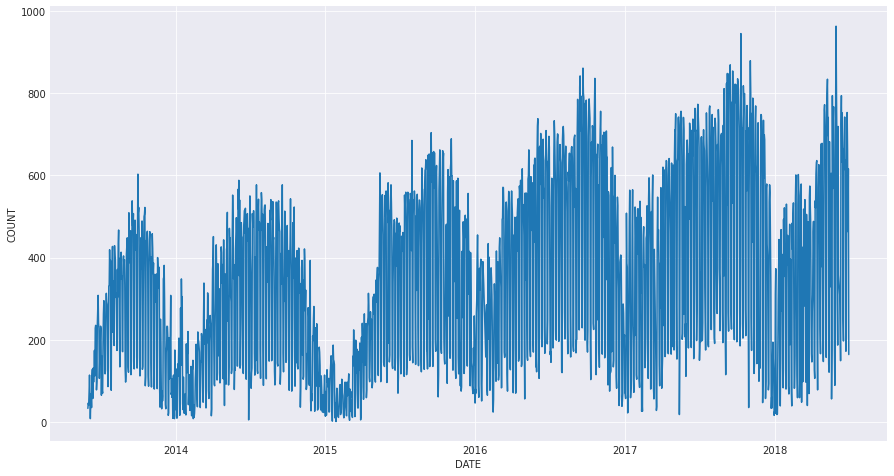

In [11]:
top_stations = snowdf.filter(F.col('START_STATION_ID').is_not_null()) \
                    .groupBy('START_STATION_ID') \
                    .count() \
                    .sort('COUNT', ascending=False) \
                    .toPandas()['START_STATION_ID'].values.tolist()

df = snowdf.filter(F.col('START_STATION_ID') == top_stations[0]) \
      .withColumn('DATE',
                  F.call_builtin('DATE_TRUNC', ('DAY', F.col('STARTTIME')))) \
      .groupBy('DATE') \
      .count() \
      .sort('DATE').toPandas()

plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='DATE', y='COUNT', data=df)





**We can definitely see the strong annual seasonality below**

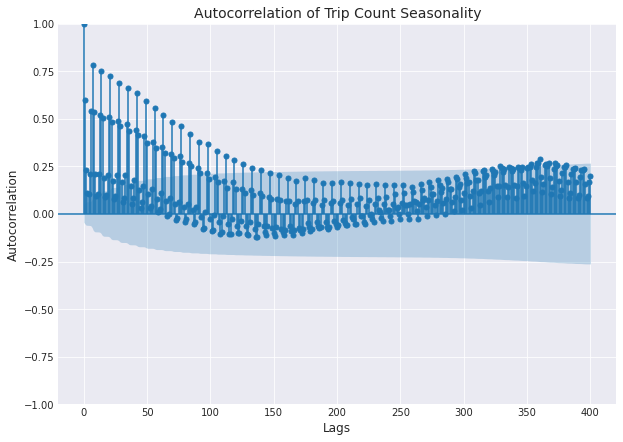

In [29]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rc("figure", figsize=(10, 7))
plot_acf(df['COUNT'], lags=400)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of Trip Count Seasonality', fontsize=14)
plt.show()

In [30]:
snowdf.with_column('DATE', F.to_date('STARTTIME')).group_by('DATE').count().sort('DATE').show(10)

------------------------
|"DATE"      |"COUNT"  |
------------------------
|NULL        |38849    |
|2013-06-01  |8722     |
|2013-06-02  |15971    |
|2013-06-03  |7598     |
|2013-06-04  |15782    |
|2013-06-05  |15690    |
|2013-06-06  |12420    |
|2013-06-07  |1226     |
|2013-06-08  |18007    |
|2013-06-09  |21034    |
------------------------



**Once we aggregate the data at the day level we have a small enough dataset to fit in memory. But we may want to provide a more granular time series (ie. hour or minute-level) or perhaps our data will grow considerably over time. In either case we can't rely on in-memory computation and will want to push-down as much computation as possible to Snowflake.**

**For exploration purposes we can see a good daily and annual seasonality in the historical data.**

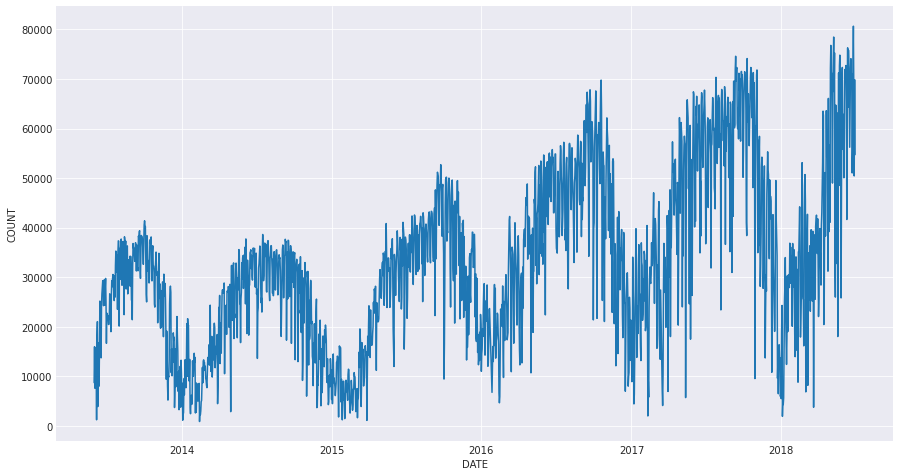

In [31]:
df = snowdf.with_column("date", F.to_date("STARTTIME")).group_by("date").count().sort("date").to_pandas()
df.head()

plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='DATE', y='COUNT', data=df)

**We may not be able to get a good model that can predict across ALL stations. Lets start with just the busiest station(s).**

In [32]:
snowdf.filter(F.col('START_STATION_ID').is_not_null()) \
      .group_by('START_STATION_ID') \
      .count() \
      .sort('COUNT', ascending=False).show()

--------------------------------
|"START_STATION_ID"  |"COUNT"  |
--------------------------------
|519                 |634428   |
|497                 |481065   |
|435                 |458626   |
|426                 |432518   |
|402                 |421812   |
|293                 |397724   |
|285                 |394995   |
|490                 |379843   |
|477                 |359838   |
|151                 |358485   |
--------------------------------



**Initially we will build with the busiest station "Central Park S & 6 Ave" which is STATION_ID=519. Later we will see how Snowpark Python allows us to tap into the powerful horizontally, scalable compute engine to parallelize this across all stations.**

In [33]:
top_stations = snowdf.filter(F.col('START_STATION_ID').is_not_null()) \
                                                   .groupBy('START_STATION_ID') \
                                                   .count() \
                                                   .sort('COUNT', ascending=False) \
                                                   .to_pandas()['START_STATION_ID'].values.tolist()
top_stations[0:10]

[519, 497, 435, 426, 402, 293, 285, 490, 477, 151]

In [34]:
df = snowdf.filter(F.col('START_STATION_ID') == top_stations[0]) \
      .withColumn('DATE', 
                  F.call_builtin('DATE_TRUNC', ('DAY', F.col('STARTTIME')))) \
      .groupBy('DATE') \
      .count() \
      .sort('DATE').to_pandas()

df.head()

,DATE,COUNT
0,2013-06-01,33
1,2013-06-02,46
2,2013-06-03,41
3,2013-06-04,72
4,2013-06-05,114


** Below We can see what looks like daily, weekly and annual periodicity as well as a slight upward trend over years**

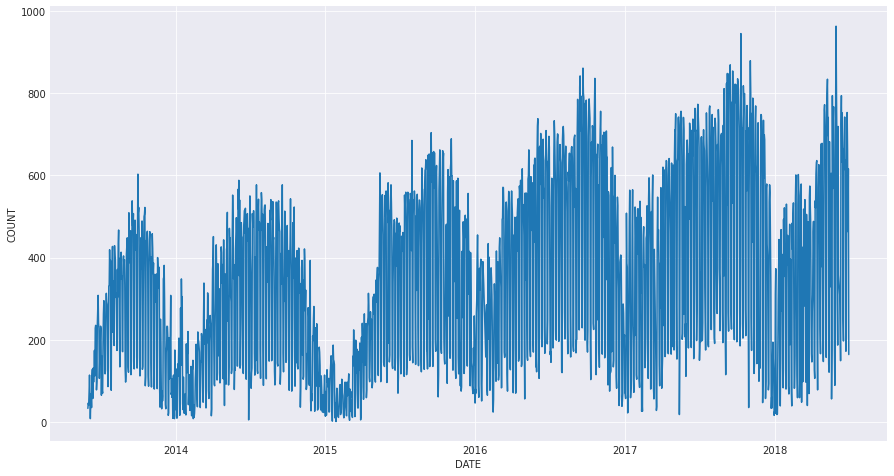

In [35]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='DATE', y='COUNT', data=df)

In [0]:
# Write recipe outputs
TRIPS_EDA = dataiku.Dataset("TRIPS_EDA")
dku_snowpark.write_with_schema(TRIPS_EDA, df)



